# Xpand IT DS Challenge

This notebook contains the template you should use to present your code, results and conclusions. You should keep the main structure intact to make it easier to evaluate and compare in the end.

## Dataset
You can find the dataset in the data folder of the repository. The folder contains two files:
* dow_jones_index.data - dataset data
* dow_jones_index.names - dataset information and details

## Business Analysis
Here you should conduct a brief analysis of what is Dow Jones Index. You can enumerate the main topics to take into account based on the dataset provided as well as your understandings of the variables.


-----
The Dow Jones Industrial Average (DJIA) is one of the oldest and most widely followed stock market indices, it has 30 large publicly traded companies in the United States. It serves as a measure of the overall health of the U.S. economy, reflecting the performance of key sectors such as technology, finance, healthcare, and industrial. Each company’s stock price in the DJIA contributes to the index based on a price-weighted calculation.The dataset contains weekly historical data for the first two quarters of 2011, focusing on variables like opening and closing prices, volume, and percent changes and it has been used in computational investing research

-----


## Data Understanding
During the data understanding phase, you should focus on understanding what each variable represents, compute statistics and visualizations. Some questions that may guide your work follow:
* Feature engineering: should new features be created from the existing ones?
* What will be your features and your label?
* Is the dataset ready for the prediction task? (ex: missing values)
* How will the data be split into train and test sets?

-----

In [2]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fgr
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

c:\Users\p059043\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Loading

In [3]:
df = pd.read_csv("data/dow_jones_index.data", sep=',')
print(df.shape)
print(df.head(5))

(750, 16)
   quarter stock       date    open    high     low   close     volume  \
0        1    AA   1/7/2011  $15.82  $16.72  $15.78  $16.42  239655616   
1        1    AA  1/14/2011  $16.71  $16.71  $15.64  $15.97  242963398   
2        1    AA  1/21/2011  $16.19  $16.38  $15.60  $15.79  138428495   
3        1    AA  1/28/2011  $15.87  $16.63  $15.82  $16.13  151379173   
4        1    AA   2/4/2011  $16.18  $17.39  $16.18  $17.14  154387761   

   percent_change_price  percent_change_volume_over_last_wk  \
0               3.79267                                 NaN   
1              -4.42849                            1.380223   
2              -2.47066                          -43.024959   
3               1.63831                            9.355500   
4               5.93325                            1.987452   

   previous_weeks_volume next_weeks_open next_weeks_close  \
0                    NaN          $16.71           $15.97   
1            239655616.0          $16.19    

### Data Inspection

In [4]:
#Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

In [5]:
#Return number of missing values for each column
df.isna().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

### Data Cleaning

In [6]:
#Convert stock to category and date to datetime
df['stock'] = df['stock'].astype('category')
df['date'] = pd.to_datetime(df['date'])

#Select all the remeining object columns (which are actually currency columns)
currency_features = df.select_dtypes(include=['object']).columns
#Remove the dollar sign from currency columns and convert to float
df[currency_features] = df[currency_features].replace('[\$,]', '', regex=True).astype(float)

#Check the types
print(df.dtypes)

quarter                                        int64
stock                                       category
date                                  datetime64[ns]
open                                         float64
high                                         float64
low                                          float64
close                                        float64
volume                                         int64
percent_change_price                         float64
percent_change_volume_over_last_wk           float64
previous_weeks_volume                        float64
next_weeks_open                              float64
next_weeks_close                             float64
percent_change_next_weeks_price              float64
days_to_next_dividend                          int64
percent_return_next_dividend                 float64
dtype: object


### Exploratory Data Analysis (EDA)

In [7]:
#Summary statistics for the dataset
df.describe().T.apply(lambda s: s.apply('{0:.3f}'.format))

count           mean            std  \
quarter                             750.000          1.520          0.500   
open                                750.000         53.652         32.639   
high                                750.000         54.670         33.216   
low                                 750.000         52.640         32.119   
close                               750.000         53.729         32.789   
volume                              750.000  117547801.407  158438089.361   
percent_change_price                750.000          0.050          2.518   
percent_change_volume_over_last_wk  720.000          5.594         40.543   
previous_weeks_volume               720.000  117387644.835  159232227.996   
next_weeks_open                     750.000         53.702         32.778   
next_weeks_close                    750.000         53.889         33.017   
percent_change_next_weeks_price     750.000          0.238          2.680   
days_to_next_dividend               750.000         52.525         46.335   
percent_return_next_dividend        750.000          0.692          0.305   

                                            min           25%           50%  \
quarter                                   1.000         1.000         2.000   
open                                     10.590        29.830        45.970   
high                                     10.940        30.627        46.885   
low                                      10.400        28.720        44.800   
close                                    10.520        30.365        45.930   
volume                              9718851.000  30866243.250  53060885.000   
percent_change_price                    -15.423        -1.288         0.000   
percent_change_volume_over_last_wk      -61.433       -19.804         0.513   
previous_weeks_volume               9718851.000  30678320.000  52945558.000   
next_weeks_open                          10.520        30.315        46.015   
next_weeks_close                         10.520        30.463        46.125   
percent_change_next_weeks_price         -15.423        -1.222         0.101   
days_to_next_dividend                     0.000        24.000        47.000   
percent_return_next_dividend              0.066         0.535         0.681   

                                              75%             max  
quarter                                     2.000           2.000  
open                                       72.715         172.110  
high                                       74.288         173.540  
low                                        71.037         167.820  
close                                      72.667         170.580  
volume                              132721823.750  1453438639.000  
percent_change_price                        1.651           9.882  
percent_change_volume_over_last_wk         21.801         327.409  
previous_weeks_volume               133322975.250  1453438639.000  
next_weeks_open                            72.715         172.110  
next_weeks_close                           72.915         174.540  
percent_change_next_weeks_price             1.846           9.882  
days_to_next_dividend                      69.000         336.000  
percent_return_next_dividend                0.854           1.564

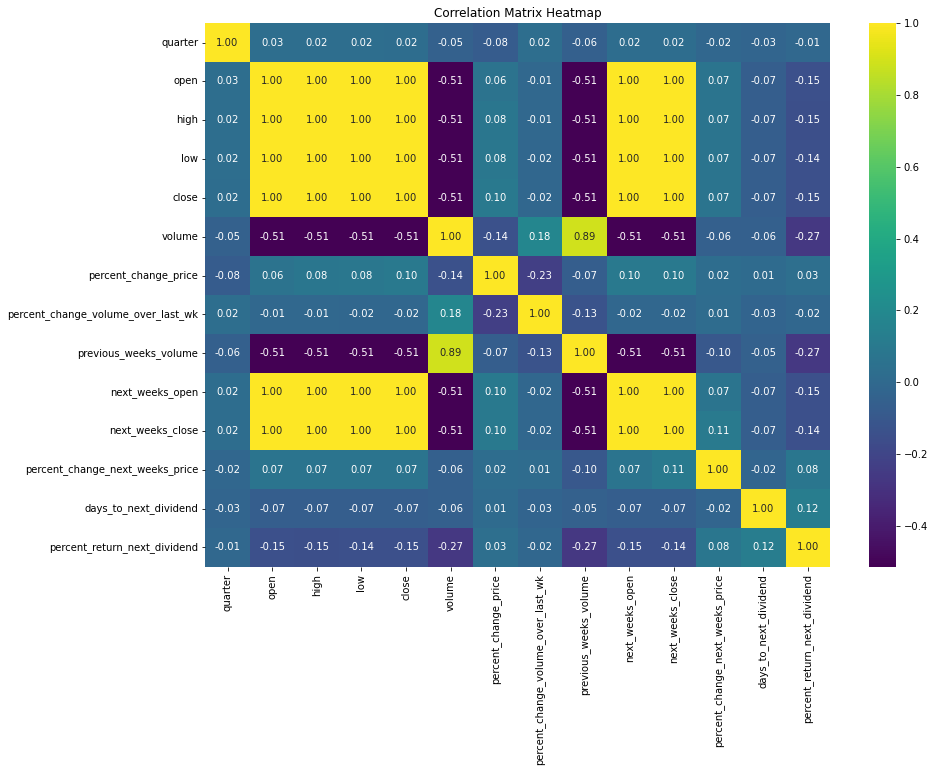

In [8]:
#Function to plot the correlation matrix heatmap of all numerical variables in data
def correlation_matrix(df):
    columns_of_interest = df.select_dtypes(include=[np.number]).columns
    df_selected = df[columns_of_interest]

    # Calculate the correlation matrix
    correlation_matrix = df_selected.corr(method = 'pearson')

    # Configure the size of the figure
    plt.figure(figsize=(14, 10))

    # Correlation heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Matrix Heatmap')
    plt.show()

correlation_matrix(df)

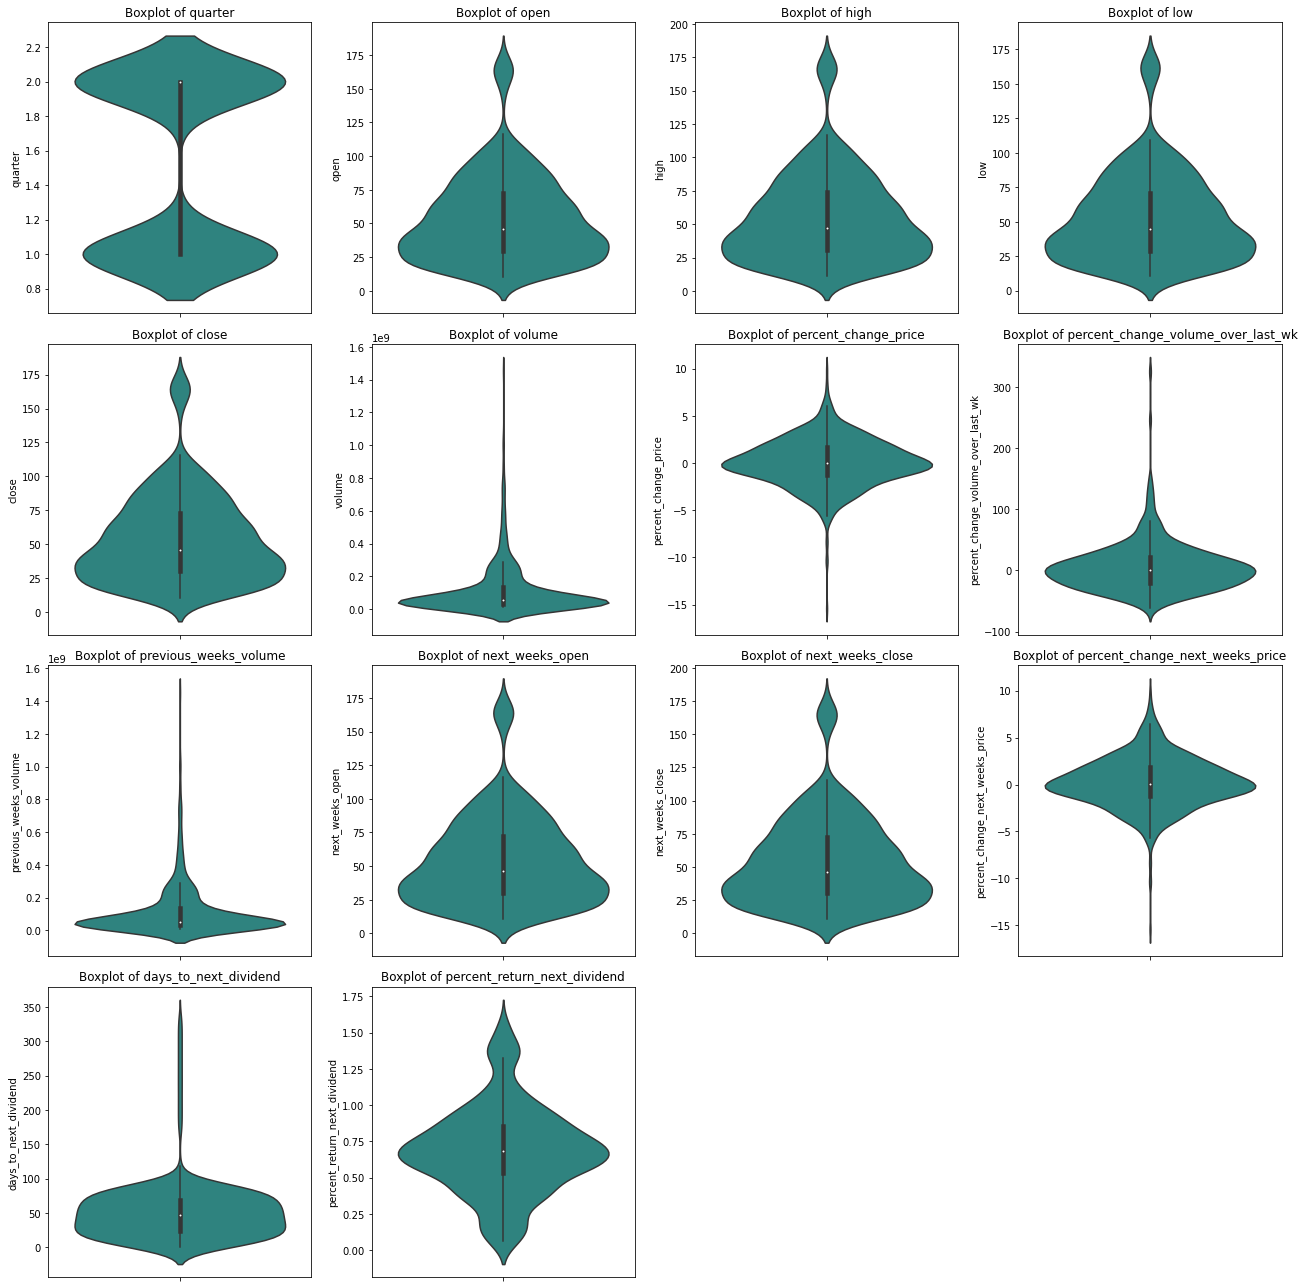

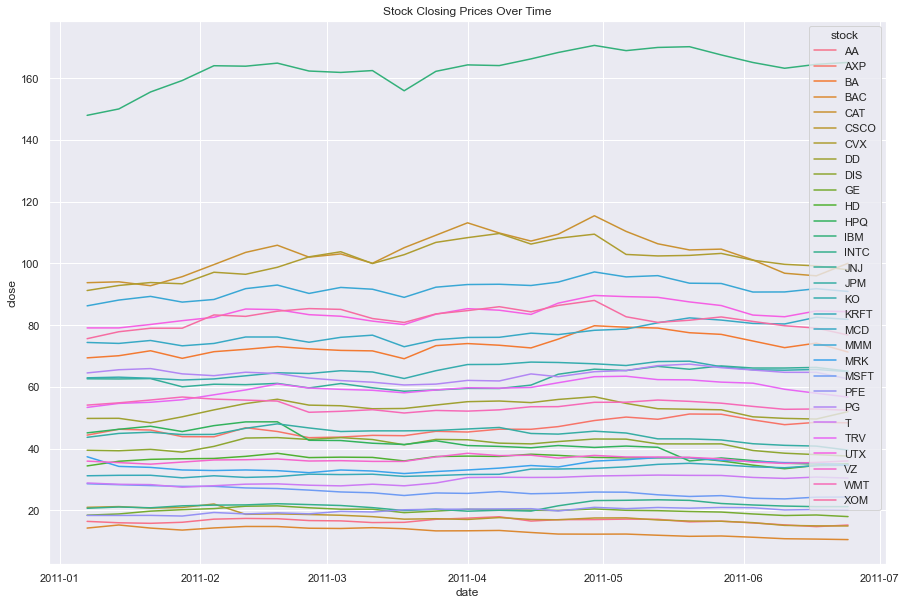

In [9]:
#Function to create violin plots of all numerical variables in data, checking distribution and density
def plot_violins(data):
    columns_of_interest = data.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(18, 18))

    # Loop to create boxplots for each numeric column
    for i, column in enumerate(columns_of_interest, 1):
        plt.subplot(4, 4, i)
        sns.violinplot(data=data, y=column, palette='viridis')
        plt.title(f'Boxplot of {column}')
        plt.ylabel(column)

    plt.tight_layout()
    plt.grid(False)
    plt.show()
    
plot_violins(df)

#Line plot of stock closing prices over time
def line_plot_feature(data, column):
    sns.set_theme(rc={'figure.figsize':(15, 10)})
    lineplot = sns.lineplot(data=data, x='date', y= column, hue='stock')
    plt.title('Stock Closing Prices Over Time')
    plt.show()

line_plot_feature(df, 'close')

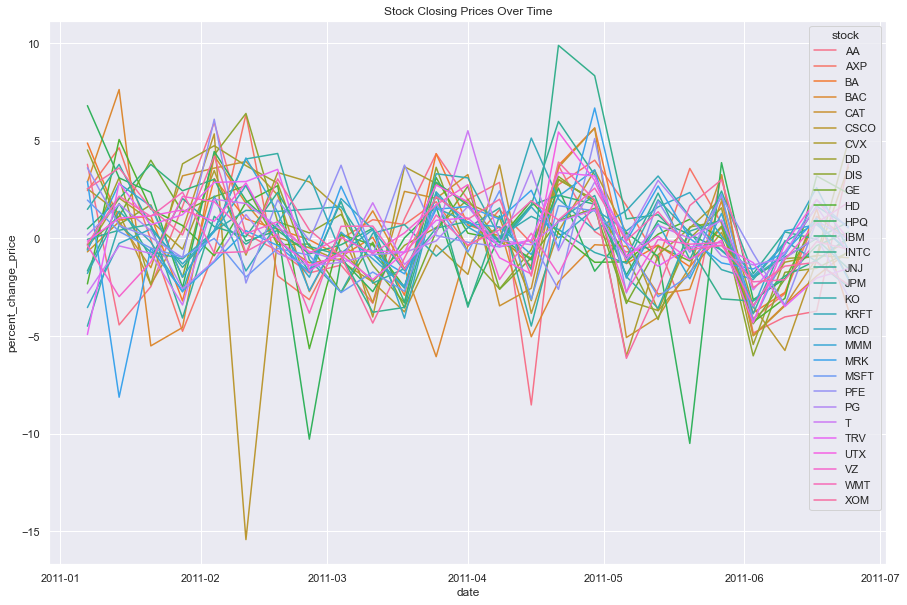

In [10]:
line_plot_feature(df, 'percent_change_price')

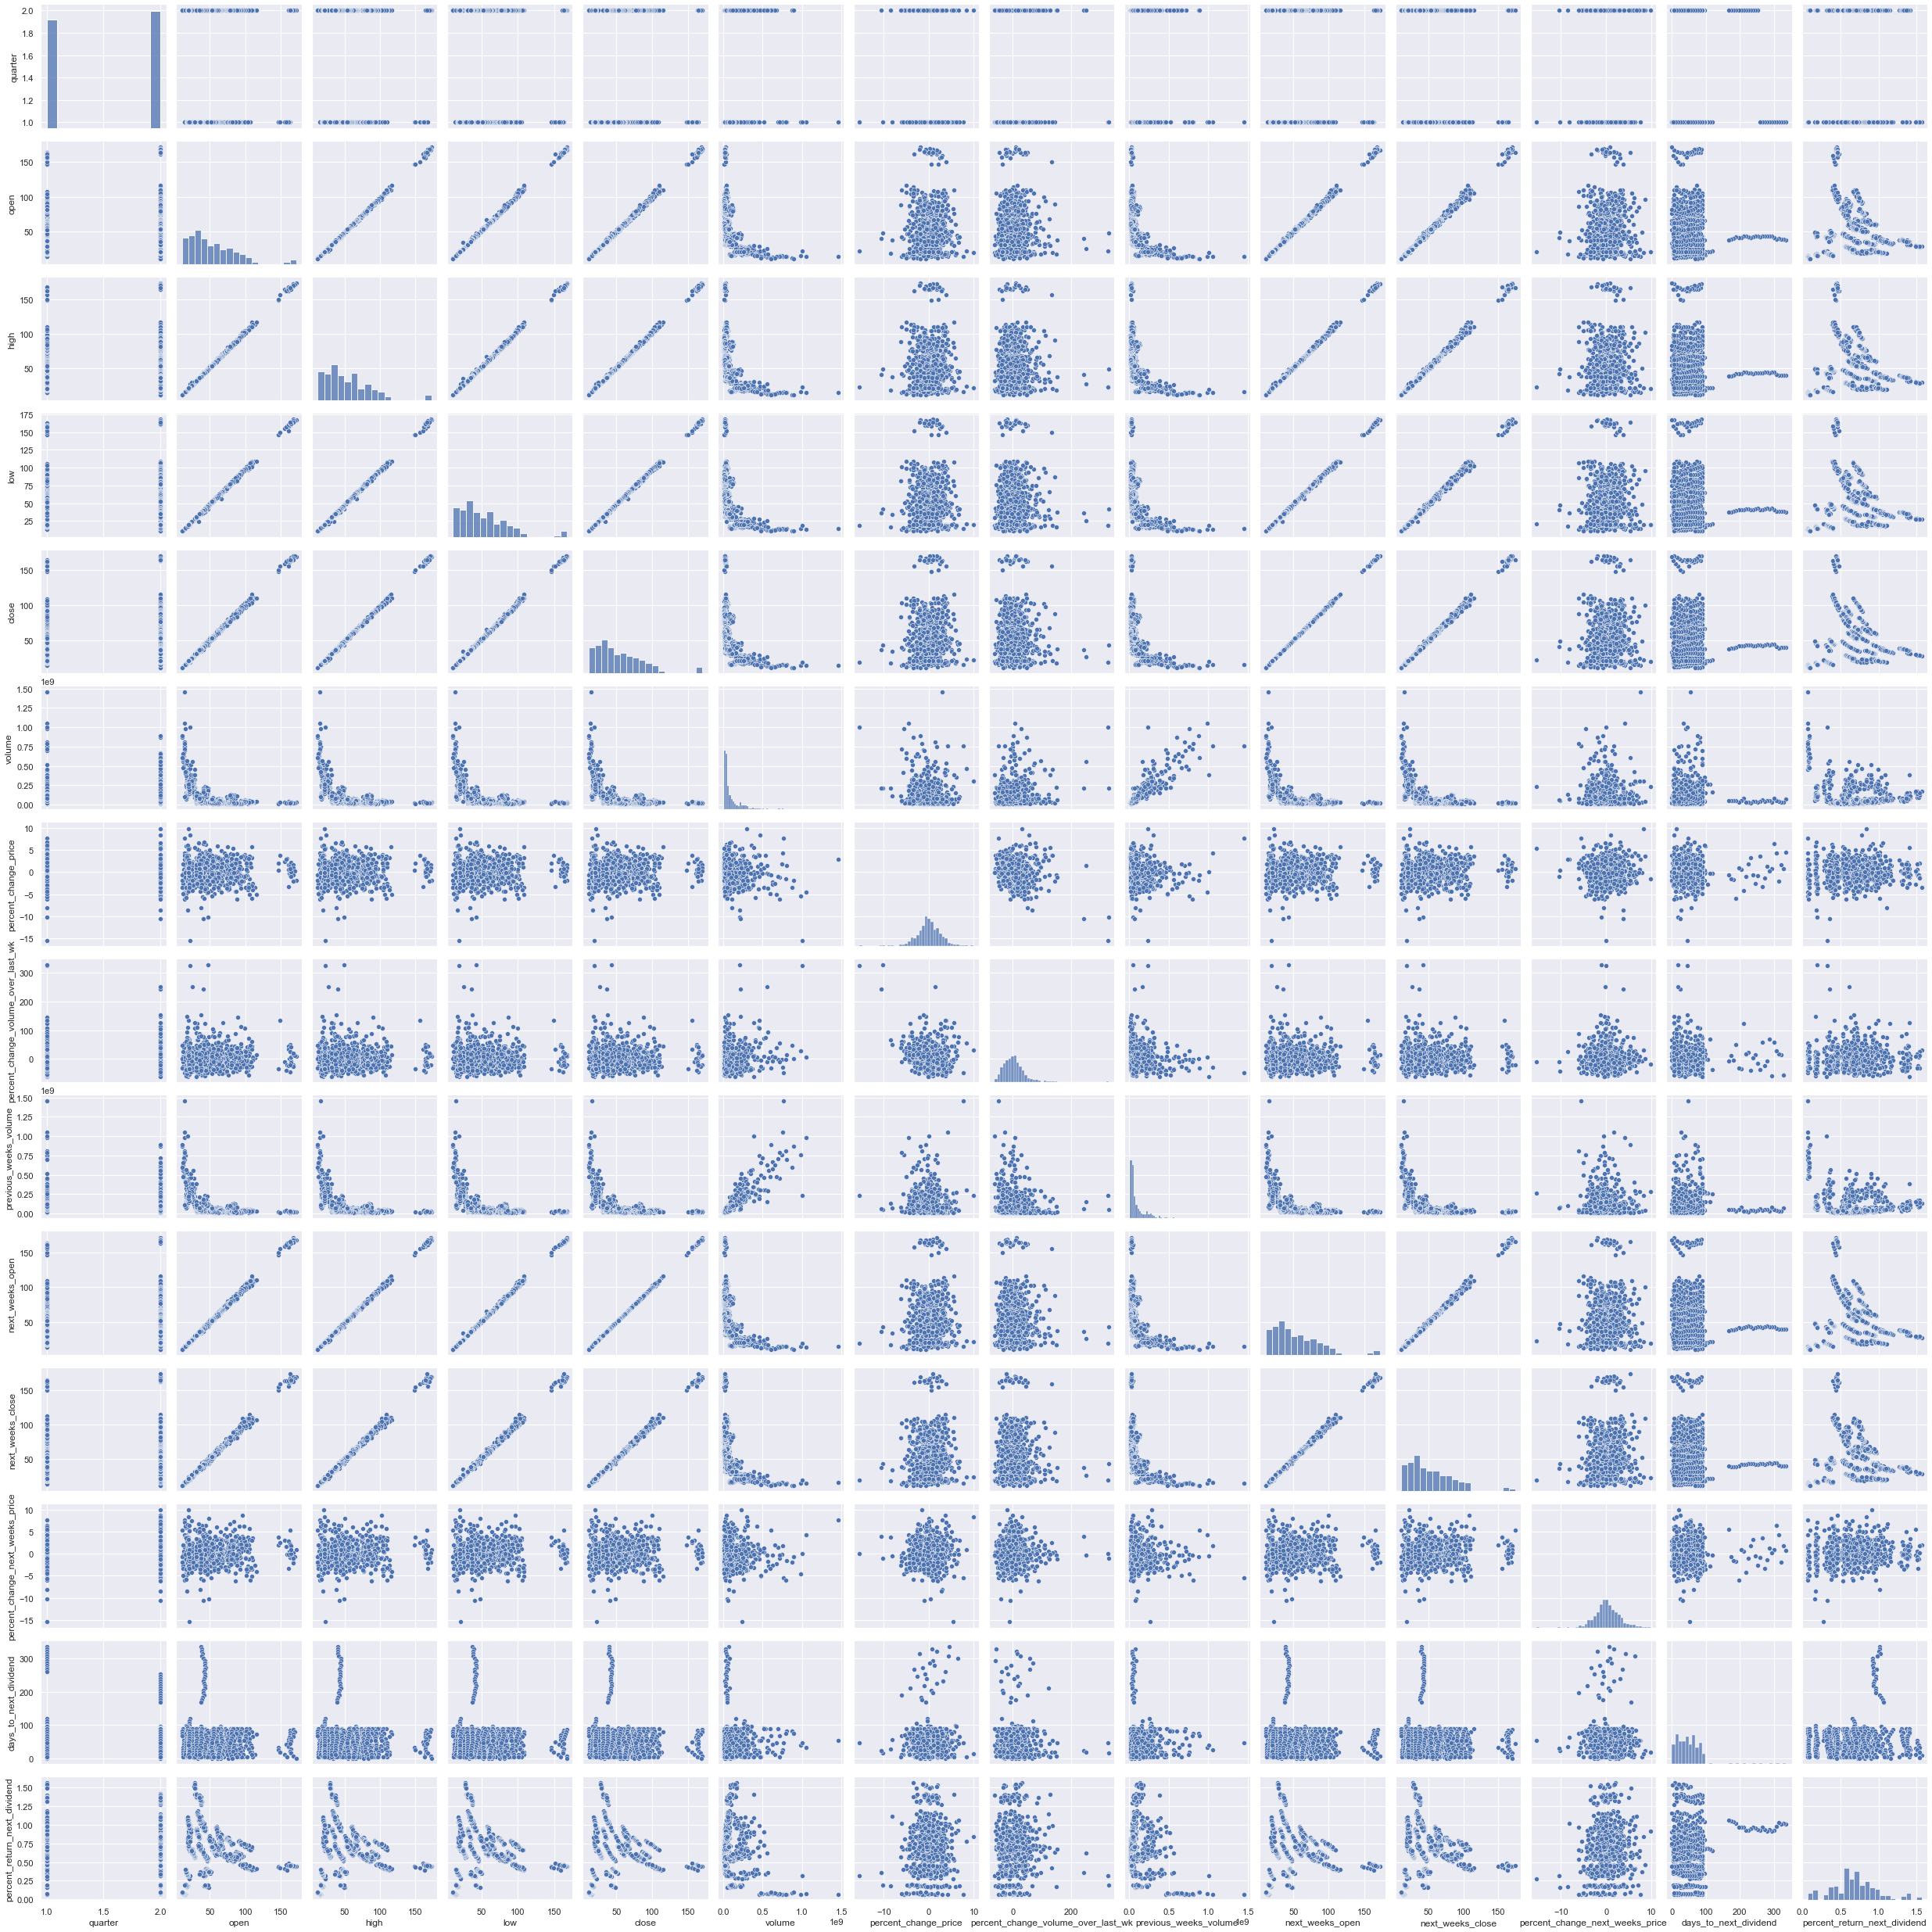

In [11]:
columns_of_interest = df.select_dtypes(include=[np.number]).columns
sns.pairplot(df[columns_of_interest])
plt.show()

<Figure size 1080x864 with 0 Axes>

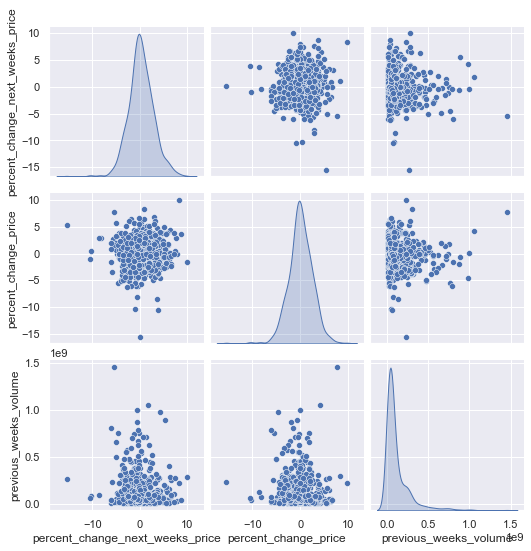

In [12]:
# Define the viridis colormap
viridis_palette = sns.color_palette("viridis", as_cmap=True)

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Create a pair plot with the viridis colormap
pair_plot = sns.pairplot(df[['percent_change_next_weeks_price', 'percent_change_price', 'previous_weeks_volume']], 
                         diag_kind='kde', 
                         markers='o',
                         palette=viridis_palette)


### Feature Engineering

In [13]:
#Calculate volatility (high-low spread)
df['volatility'] = df['high'] - df['low']

#Rolling averages and volatility over 3 weeks
df['rolling_avg_3w'] = df.groupby('stock')['close'].rolling(window=3).mean().reset_index(0, drop=True)
df['rolling_vol_3w'] = df.groupby('stock')['volatility'].rolling(window=3).mean().reset_index(0, drop=True)

#df['ma_7'] = df.groupby('stock')['close'].rolling(window=7).mean().reset_index(0, drop=True)
#df['ma_3'] = df.groupby('stock')['close'].rolling(window=3).mean().reset_index(0, drop=True)

#Lag features of previous week's percent change
df['lag_1'] = df.groupby('stock')['percent_change_price'].shift(1)
df['lag_2'] = df.groupby('stock')['percent_change_price'].shift(2)

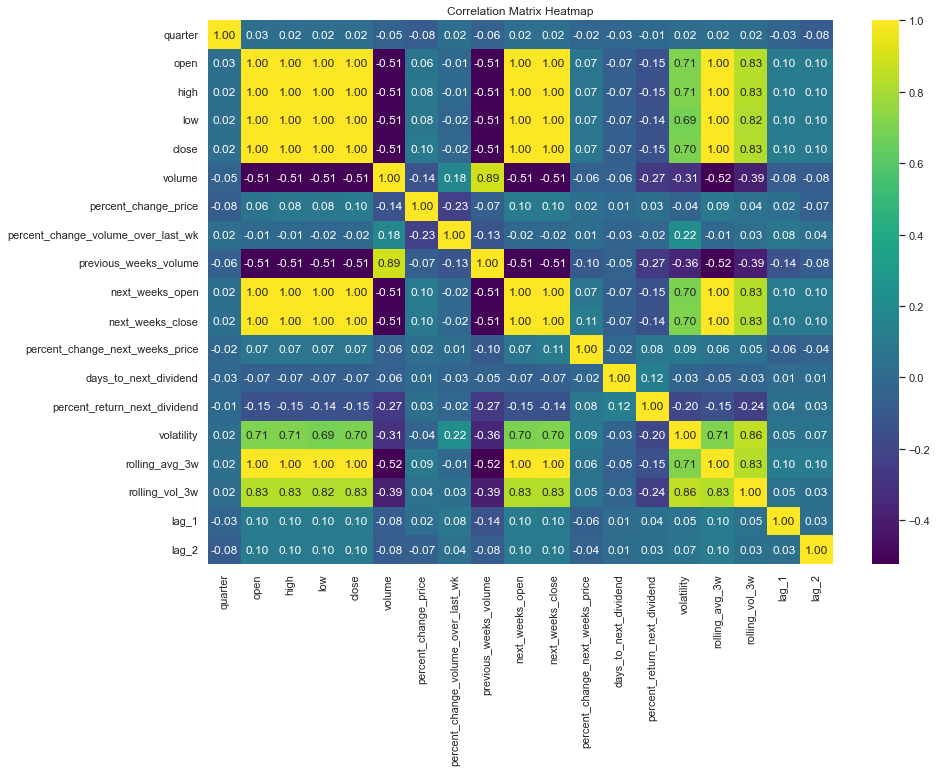

In [14]:
correlation_matrix(df)

-----

Some entries had missing values, particularly in the price columns. These were handled through data cleaning, removing rows with incomplete data to ensure consistency in analysis. Outliers were observed, likely reflecting volatile weeks that could skew predictions.

The high-low price spread was used to measure volatility. Stocks with higher volatility indicate more price fluctuations and potential risk, which might signal higher returns or losses.

To capture the effect of past performance on future stock prices, lag features were created (e.g., previous week’s price). Rolling averages over 3-4 weeks helped smooth short-term fluctuations, identifying longer-term trends.

The stock volume also seems useful for understanding market activity and momentum, as high trading volumes could hint at increased interest in a stock.

The dataset is well-structured for time series analysis. Through cleaning, feature engineering (e.g., lag features, rolling averages, and volatility), i have tried to extract key insights to better predict stock performance in the upcoming modeling phase

-----

## Modelling
In this phase, your main goal is to develop and describe your approach to the solution of the problem. Some guidelines to help you:
* What metrics will you use to evaluate your solutions?
* What are some algorithms that can lead to good results? And why?
* Describe in detail your thought process during the development of your solution.
* Present your results.


-----


### XGBoost

In [15]:
#Create target column: 1 if it's the best-performing stock for that week, otherwise 0
df['best_stock'] = df.groupby('date')['percent_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))

In [16]:
#Define features and target
features_with_date = ['date', 'stock', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 
            'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
            'days_to_next_dividend', 'percent_return_next_dividend', 'volatility', 'rolling_avg_3w', 'rolling_vol_3w', 'lag_1', 'lag_2']


features = ['open', 'high', 'low', 'close', 'volume', 'percent_change_price', 
            'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
            'days_to_next_dividend', 'percent_return_next_dividend', 'volatility', 'rolling_avg_3w', 'rolling_vol_3w', 'lag_1', 'lag_2']

target = 'best_stock'

#Create a copy of dataframe and drop missing values
df_xgb = df.copy()
df_xgb = df_xgb.dropna()

X = df_xgb[features_with_date]
y = df_xgb[target]

# Train-test split - first 70% for training, last 20% for testing
train_size = int(len(df_xgb) * 0.7)
train_data = df_xgb.iloc[:train_size]
test_data = df_xgb.iloc[train_size:]

X_train = train_data[features_with_date]
y_train = train_data[target]
X_test = test_data[features_with_date]
y_test = test_data[target]

#smote = SMOTE(random_state=2)
#X_train_smote, y_train_smote = smote.fit_resample(X_train[features], y_train)

In [17]:
#Train XGBoost model
model = XGBClassifier(scale_pos_weight = 1.5, use_label_encoder=False)
model.fit(X_train[features], y_train)

#Evaluate performance
y_pred = model.predict(X_test[features])
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

[23:14:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       204
           1       0.00      0.00      0.00         4

    accuracy                           0.97       208
   macro avg       0.49      0.50      0.49       208
weighted avg       0.96      0.97      0.97       208



In [18]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
#Accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1:.2f}')

data_test = X_test.copy()  # Copy test data
data_test['predicted_best_stock'] = y_pred

#Merge with the original data to get the actual returns for each predicted stock
data_test = data_test.merge(df[['date', 'stock', 'percent_change_next_weeks_price']], on=['date','stock'], how='left')

#Assuming 100€ investment each week
data_test['predicted_return'] = data_test['percent_change_next_weeks_price']
cumulative_return = data_test[data_test['predicted_best_stock']==1]['predicted_return'].sum()
print(f'Cumulative Return: {cumulative_return} EUR')

Accuracy: 0.9711538461538461
Precision: 0.0
Recall: 0.0
F1 Score: 0.00
Cumulative Return: -2.7055936000000003 EUR


### Time Series Forecasting with LSTM

In [20]:
#Create a copy of dataframe then sort and drop missing values
df_lstm = df.copy()
df_lstm.set_index('date', inplace=True)
df_lstm.sort_index(axis=0,inplace=True)

features = ['close','volume','volatility','rolling_vol_3w','rolling_avg_3w','percent_change_price','previous_weeks_volume','percent_return_next_dividend','percent_change_next_weeks_price']
target = 'percent_change_next_weeks_price'

df_lstm = df_lstm[features]
df_lstm.fillna(0, inplace=True)

#Preprocessing for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length][:-1]) # Use seq_length data points as input (exclude the target)
        y.append(data[i+seq_length][-1]) #Target is 'percent_change_next_weeks_price' (the last column)
    return np.array(X), np.array(y)

seq_length = 4  #use the last 4 weeks to predict the next week
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=120, batch_size=1, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

Epoch 1/120
522/522 [==============================] - 14s 11ms/step - loss: 0.0201
Epoch 2/120
522/522 [==============================] - 5s 10ms/step - loss: 0.0115
Epoch 3/120
522/522 [==============================] - 5s 10ms/step - loss: 0.0111
Epoch 4/120
522/522 [==============================] - 5s 10ms/step - loss: 0.0109
Epoch 5/120
522/522 [==============================] - 3s 5ms/step - loss: 0.0111
Epoch 6/120
522/522 [==============================] - 3s 5ms/step - loss: 0.0106
Epoch 7/120
522/522 [==============================] - 3s 5ms/step - loss: 0.0104
Epoch 8/120
522/522 [==============================] - 6s 11ms/step - loss: 0.0105
Epoch 9/120
522/522 [==============================] - 5s 9ms/step - loss: 0.0110
Epoch 10/120
522/522 [==============================] - 5s 9ms/step - loss: 0.0102
Epoch 11/120
522/522 [==============================] - 5s 9ms/step - loss: 0.0106
Epoch 12/120
522/522 [==============================] - 5s 9ms/step - loss: 0.0104
Epoch 1

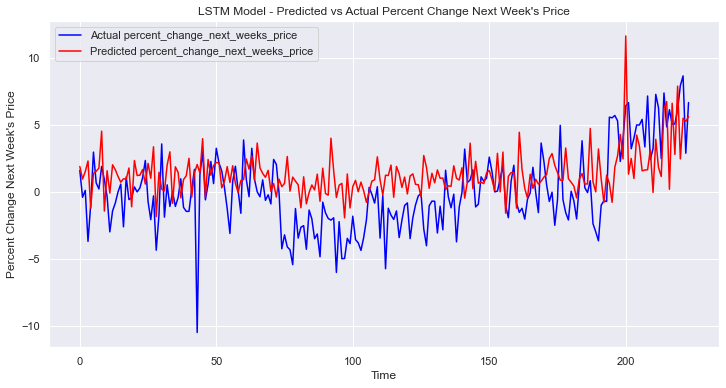

Root Mean Squared Error (MSE): 2.98820216030749


c:\Users\p059043\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
#Invert the scaling of the predicted data (back to original scale)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

#Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='blue', label='Actual percent_change_next_weeks_price')
plt.plot(y_pred_rescaled, color='red', label='Predicted percent_change_next_weeks_price')
plt.title('LSTM Model - Predicted vs Actual Percent Change Next Week\'s Price')
plt.xlabel('Time')
plt.ylabel('Percent Change Next Week\'s Price')
plt.legend()
plt.show()

rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
print(f'Root Mean Squared Error (MSE): {rmse}')

In [22]:
def cumulative_returns(data):

    data['best_actual_stock'] = data.groupby('date')['percent_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))
    data['best_predicted_stock'] = data.groupby('date')['predicted_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))

    actual_returns_add = data[data['best_actual_stock']==1]['percent_change_next_weeks_price'].sum()
    predicted_returns_add = data[data['best_predicted_stock']==1]['percent_change_next_weeks_price'].sum()

    actual_returns_array = data[data['best_actual_stock']==1]['percent_change_next_weeks_price'].to_numpy()
    predicted_returns_array = data[data['best_predicted_stock']==1]['percent_change_next_weeks_price'].to_numpy()

    # Cumulative returns for both actual and predicted values (assuming initial investment of 100€)
    initial_investment = 100
    cumulative_actual_return = np.cumsum(actual_returns_array) * initial_investment / 100 + initial_investment
    cumulative_predicted_return = np.cumsum(predicted_returns_array) * initial_investment / 100 + initial_investment

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_actual_return, label='Actual Cumulative Return', color='blue')
    plt.plot(cumulative_predicted_return, label='Predicted Cumulative Return', color='red')
    plt.title('Cumulative Returns (Actual vs Predicted)')
    plt.xlabel('Weeks')
    plt.ylabel('Cumulative Return (€)')
    plt.legend()
    plt.show()

    # Step 7: Evaluate model with Mean Squared Error (MSE) as an additional metric
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(actual_returns_array, predicted_returns_array)
    print(f'Mean Squared Error (MSE): {mse}')
    rmse = root_mean_squared_error(actual_returns_array, predicted_returns_array)
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Final cumulative returns
    final_actual_return = cumulative_actual_return[-1]
    final_predicted_return = cumulative_predicted_return[-1]

    print(f"Final Actual Cumulative Return: {final_actual_return:.2f} EUR")
    print(f"Final Predicted Cumulative Return: {final_predicted_return:.2f} EUR")
    print(f"Percentage of MAX returns acheived: {(100*predicted_returns_add)/actual_returns_add:.2f} %")

    print(cumulative_actual_return)
    print(cumulative_predicted_return)

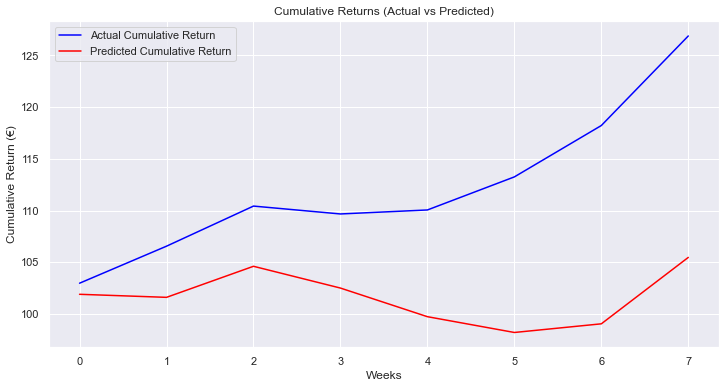

Mean Squared Error (MSE): 9.141857776357375
Root Mean Squared Error (RMSE): 3.0235505248560632
Final Actual Cumulative Return: 126.89 EUR
Final Predicted Cumulative Return: 105.47 EUR
Percentage of MAX returns acheived: 20.33 %
[102.97243  106.55398  110.43256  109.670655 110.057909 113.255759
 118.225459 126.888929]
[101.89966  101.604437 104.608677 102.502317  99.733457  98.206147
  99.043044 105.467234]


In [23]:
df_lstm_test = df_lstm[train_size:]
df_lstm_test = df_lstm_test[seq_length:]

df_lstm_test['predicted_change_next_weeks_price'] = y_pred_rescaled

cumulative_returns(df_lstm_test)

### Time Series Forecasting with Prophet

In [24]:
from prophet import Prophet

df_prophet = df.copy()
df_prophet= df_prophet.dropna()
df_prophet.sort_values(by=['date'], inplace=True)

#Remove extreme outliers based on the percent change
#remove changes greater than 3 standard deviations from the mean
mean_change = df_prophet['percent_change_next_weeks_price'].mean()
std_change = df_prophet['percent_change_next_weeks_price'].std()

df_prophet = df_prophet[(df_prophet['percent_change_next_weeks_price'] > mean_change - 3 * std_change) &
            (df_prophet['percent_change_next_weeks_price'] < mean_change + 3 * std_change)]

#Split the dataset into training and testing based on date
split = pd.to_datetime('2011-05-21')
train_data = df_prophet[df_prophet.date < split]
test_data = df_prophet[df_prophet.date >= split]


predictions = pd.DataFrame()

#Loop over each stock to fit a Prophet model and make predictions
for stock in df_prophet['stock'].unique():
    #print(f"Running Prophet model for stock: {stock}")
    
    #Filter data for the current stock
    stock_train = train_data[train_data['stock'] == stock]
    stock_test = test_data[test_data['stock'] == stock]
    
    
    #Prepare data for Prophet
    prophet_data = stock_train[['date', 'percent_change_next_weeks_price','close', 'volatility', 'rolling_avg_3w','lag_1']].copy()
    #Prophet requires 'ds' for date and 'y' for target
    prophet_data.columns = ['ds', 'y', 'close', 'volatility', 'rolling_avg_3w','lag_1']
    
    #Initialize and fit Prophet model with aditional regressors
    model = Prophet(weekly_seasonality=True)
    model.add_regressor('close')
    model.add_regressor('volatility')
    model.add_regressor('rolling_avg_3w')
    model.add_regressor('lag_1')
    model.fit(prophet_data)
    
    # Create future dataframe to predict for test set
    future = pd.DataFrame(stock_test[['date', 'close', 'volatility', 'rolling_avg_3w','lag_1']])
    future.columns = ['ds', 'close', 'volatility', 'rolling_avg_3w','lag_1']
    #Make predictions
    forecast = model.predict(future)
   
    #Store predictions with the stock information
    stock_test['predicted_change_next_weeks_price'] = forecast['yhat_lower'].values
    predictions = pd.concat([predictions, stock_test], axis=0)

23:21:14 - cmdstanpy - INFO - Chain [1] start processing
23:21:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\p059043\AppData\Local\Temp/ipykernel_12012/3688769987.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_test['predicted_change_next_weeks_price'] = forecast['yhat_lower'].values
23:21:15 - cmdstanpy - INFO - Chain [1] start processing
23:21:15 - cmdstanpy - INFO - Chain [1] done processing
23:21:15 - cmdstanpy - INFO - Chain [1] start processing
23:21:15 - cmdstanpy - INFO - Chain [1] done processing
23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done processing
23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done proces

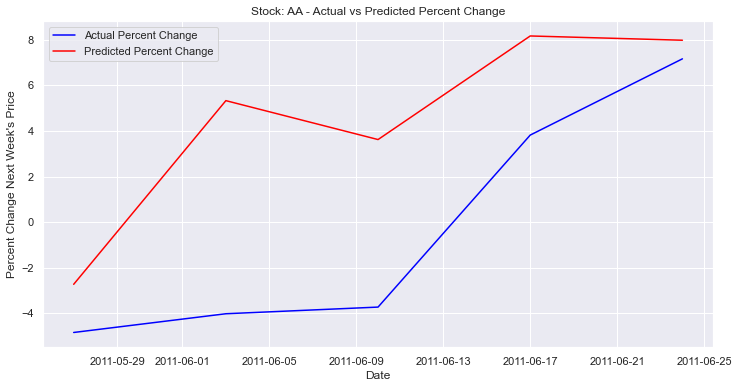

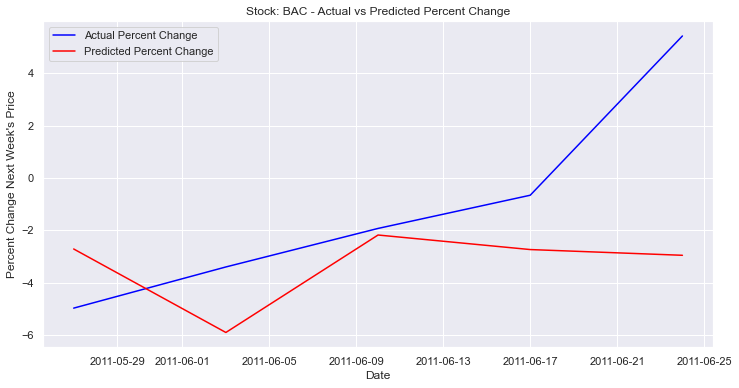

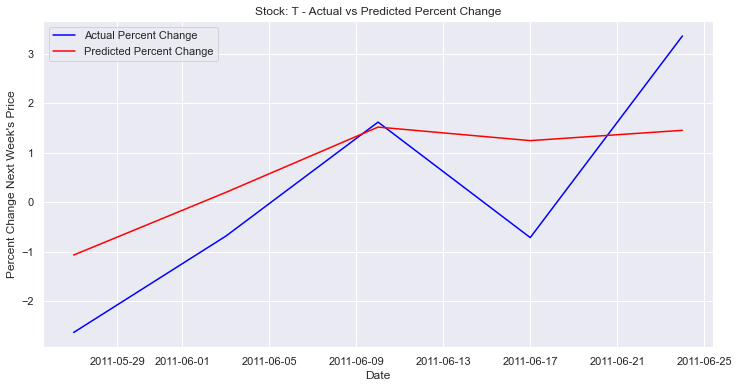

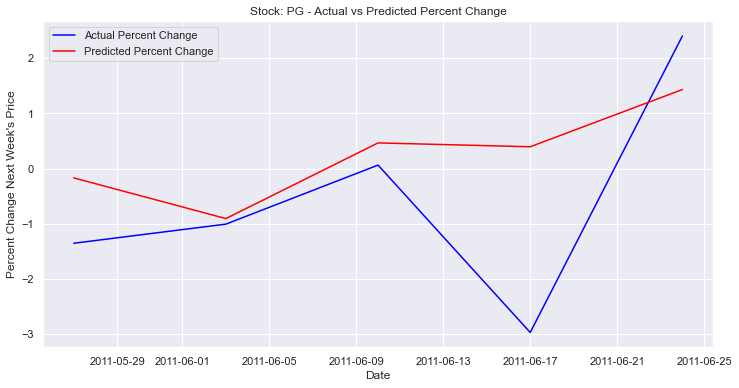

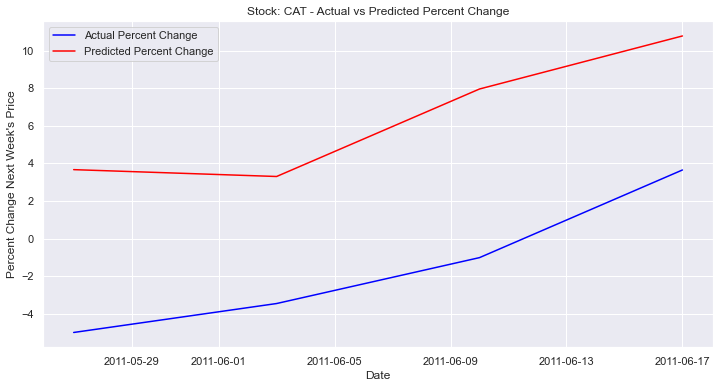

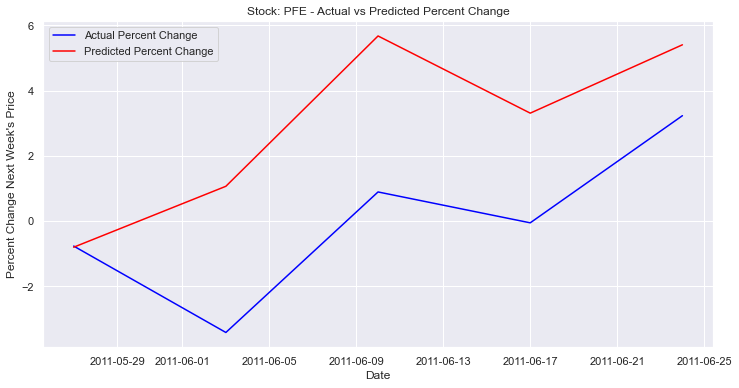

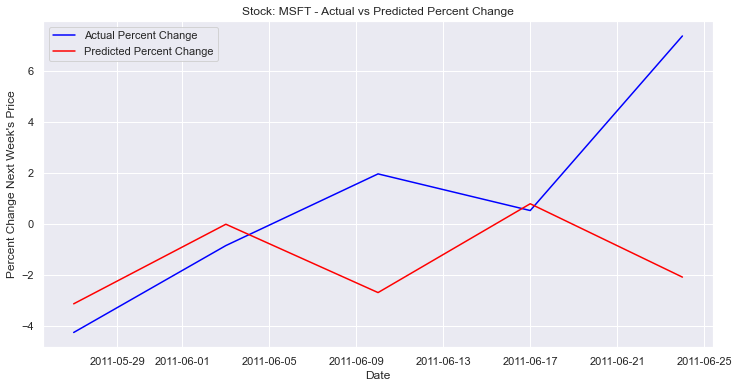

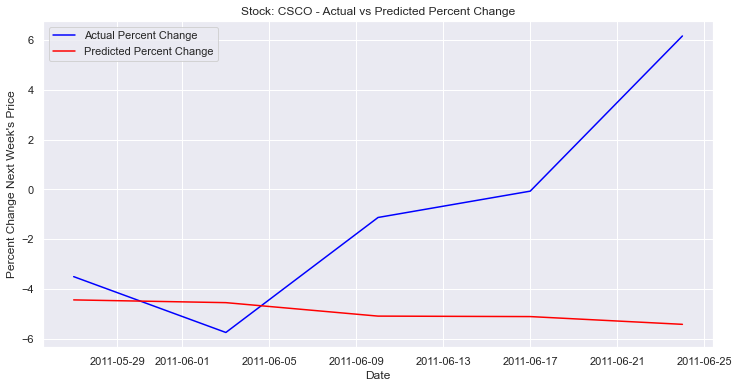

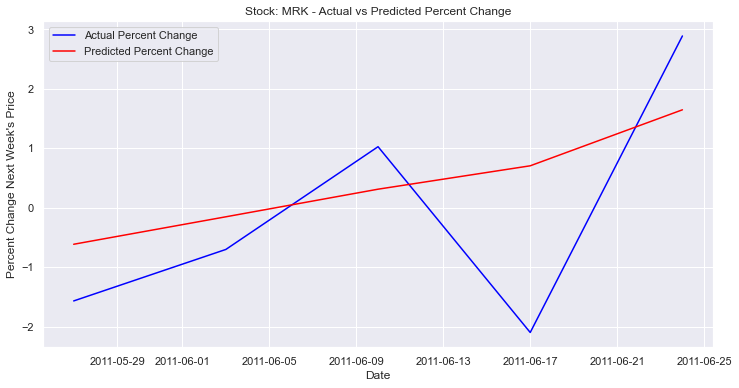

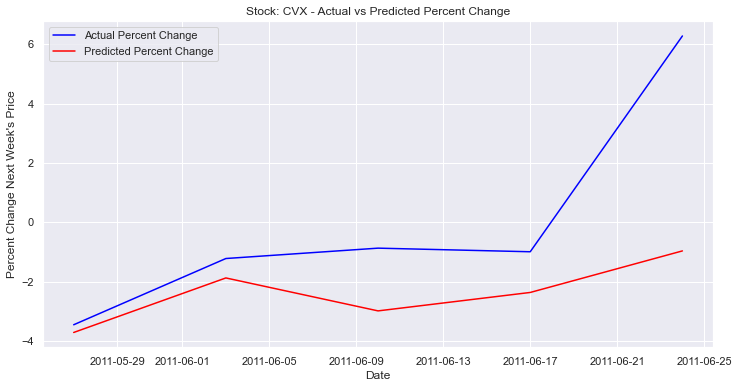

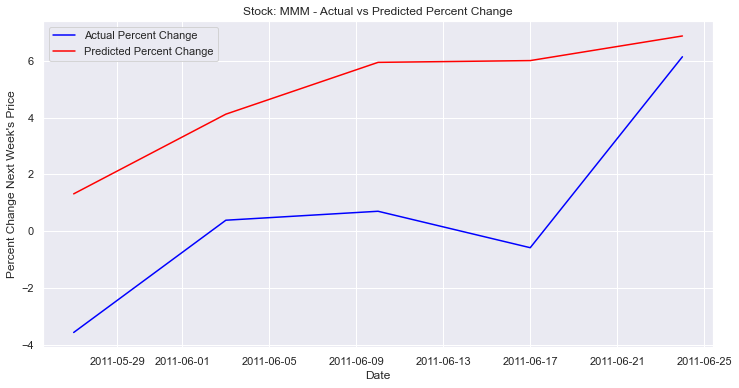

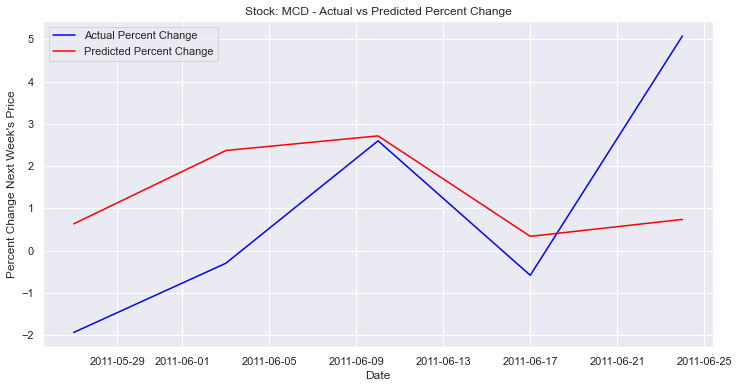

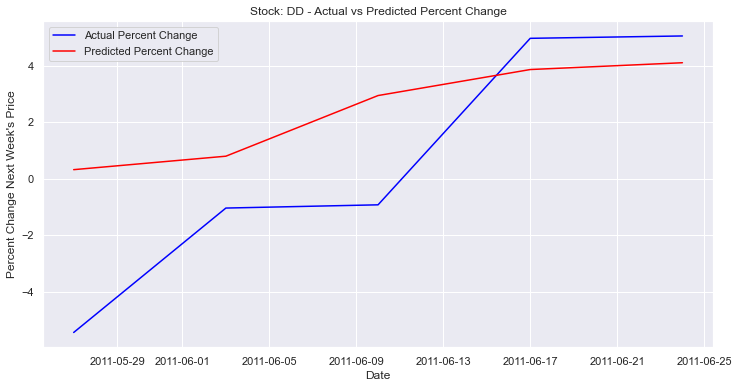

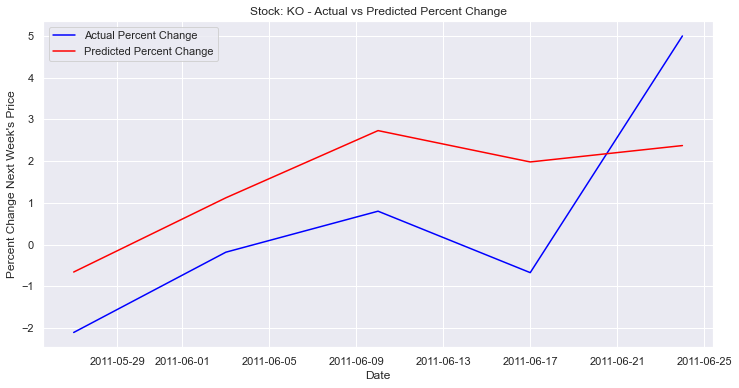

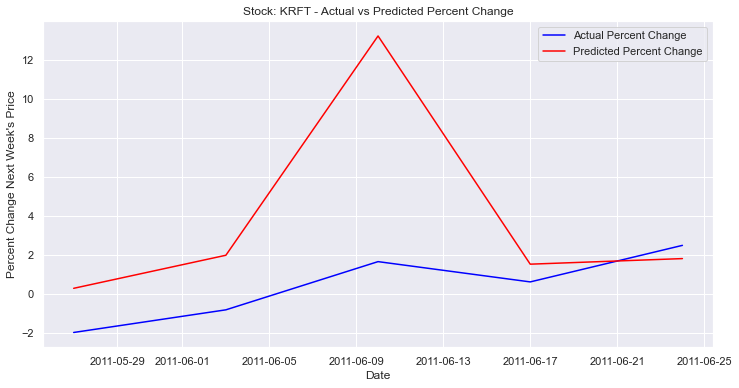

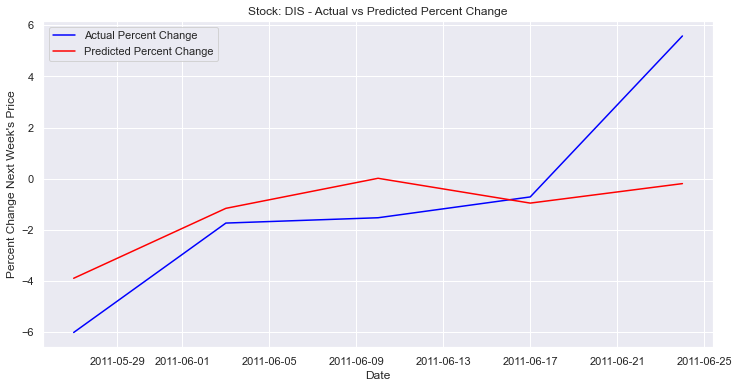

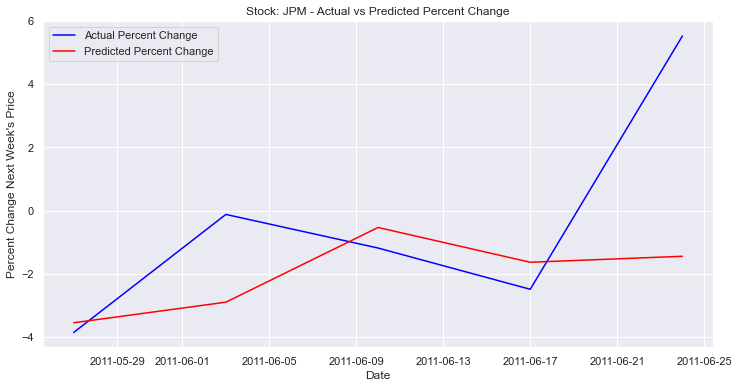

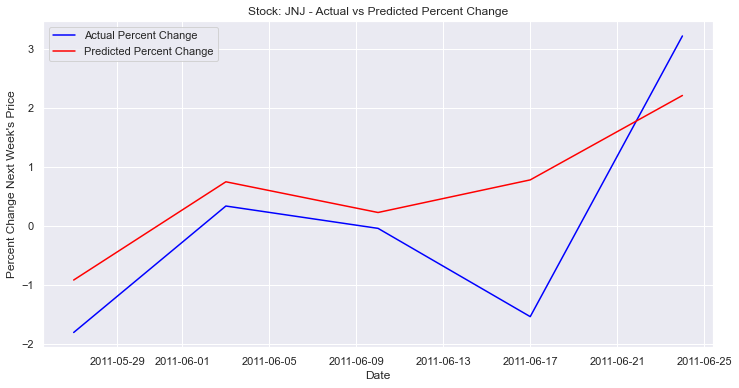

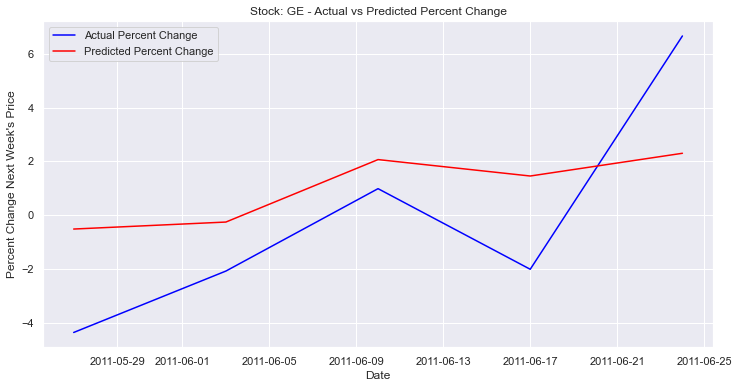

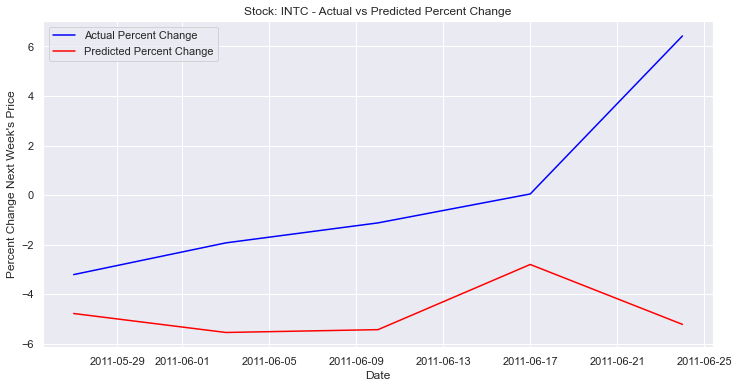

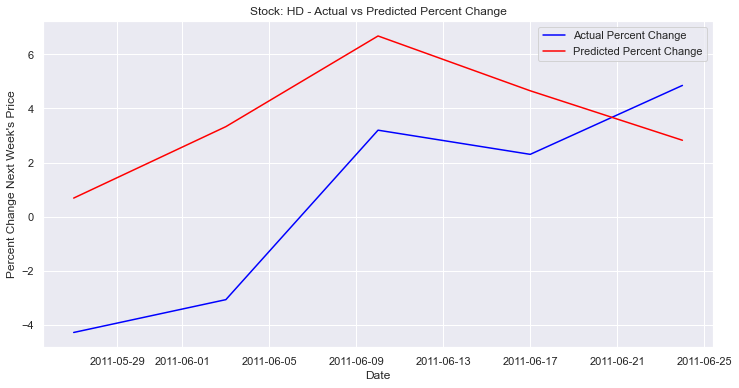

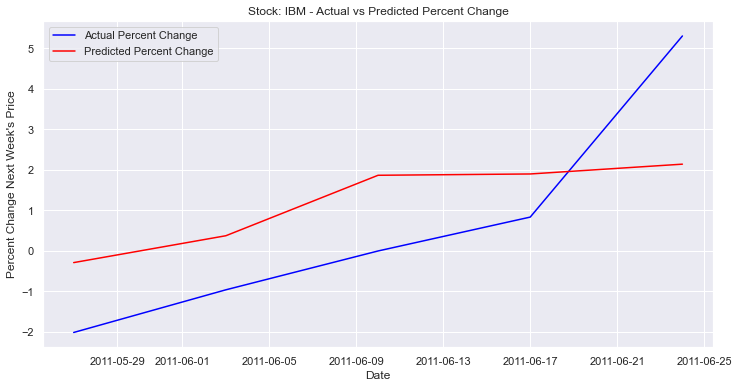

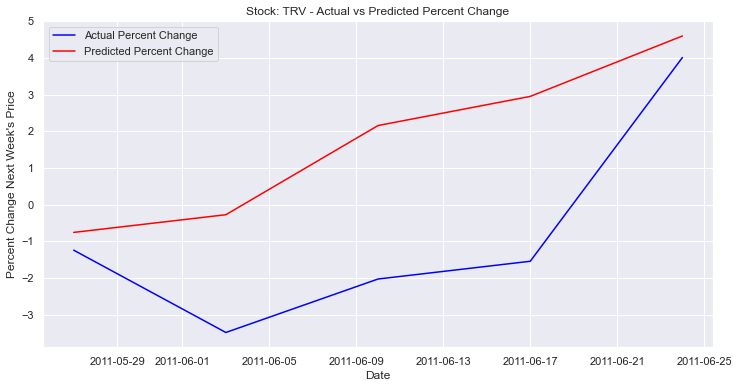

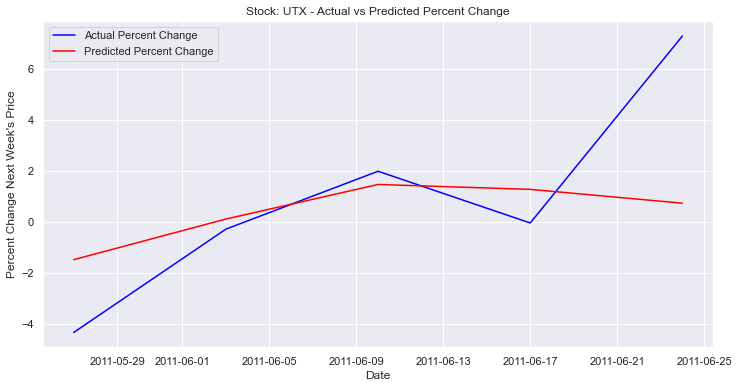

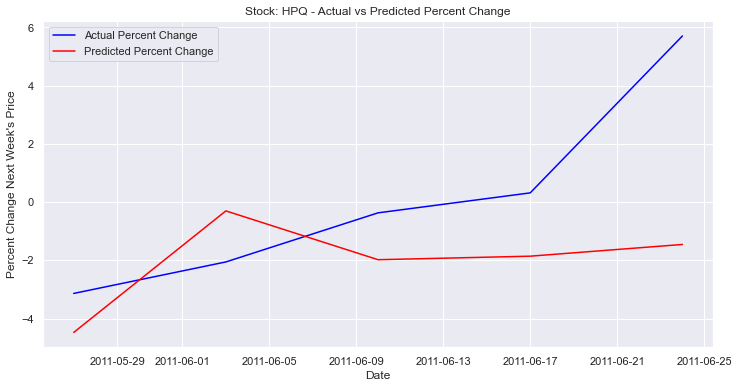

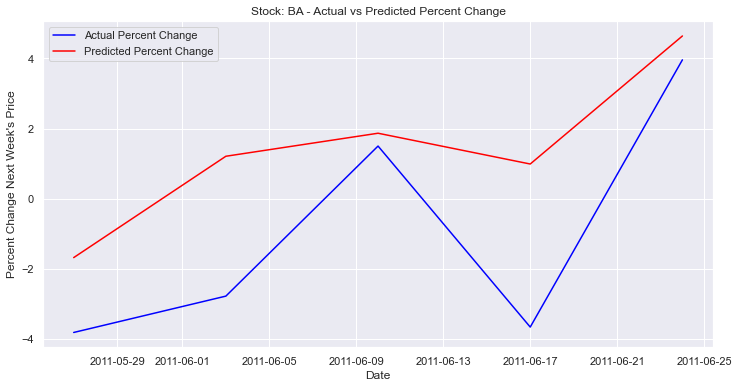

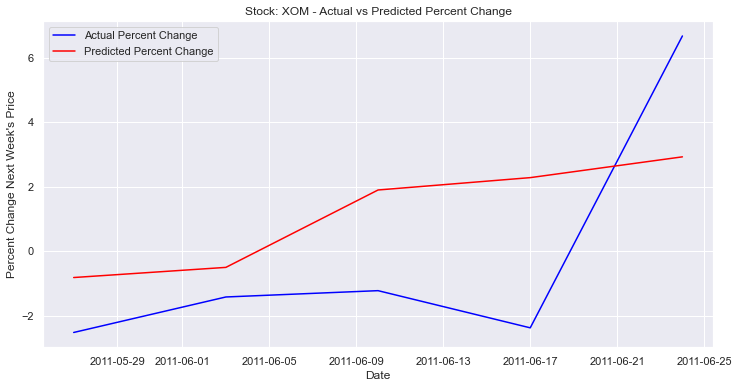

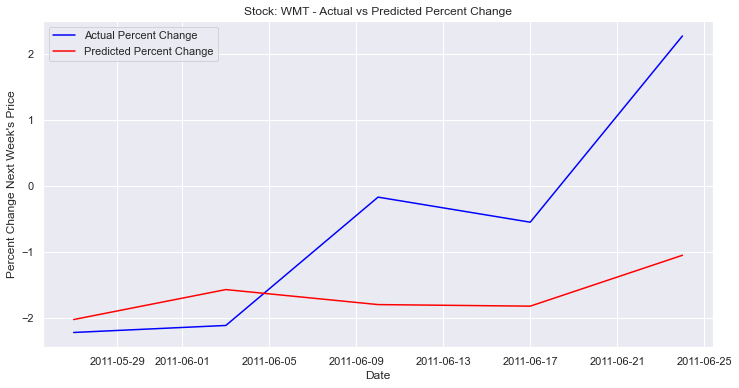

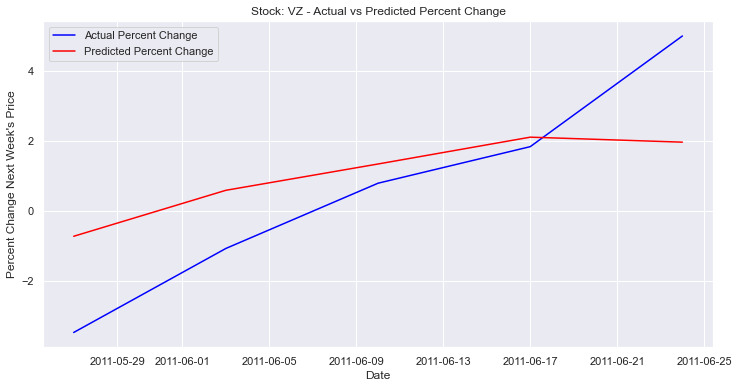

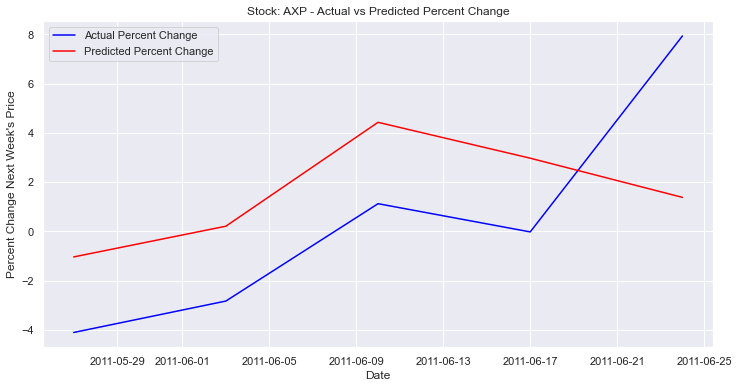

In [25]:
#Plot actual vs predicted values for each stock in the test set
for stock in df_prophet['stock'].unique():
    stock_predictions = predictions[predictions['stock'] == stock]
    
    plt.figure(figsize=(12, 6))
    plt.plot(stock_predictions['date'], stock_predictions['percent_change_next_weeks_price'], label='Actual Percent Change', color='blue')
    plt.plot(stock_predictions['date'], stock_predictions['predicted_change_next_weeks_price'], label='Predicted Percent Change', color='red')
    plt.title(f'Stock: {stock} - Actual vs Predicted Percent Change')
    plt.xlabel('Date')
    plt.ylabel('Percent Change Next Week\'s Price')
    plt.legend()
    plt.show()

In [26]:
mse = mean_squared_error(stock_predictions['percent_change_next_weeks_price'], stock_predictions['predicted_change_next_weeks_price'])
print(f"Mean Squared Error for stocks: {mse}")

rmse = root_mean_squared_error(stock_predictions['percent_change_next_weeks_price'], stock_predictions['predicted_change_next_weeks_price'])
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error for stocks: 16.31049682098648
Root Mean Squared Error (RMSE): 4.038625610400954


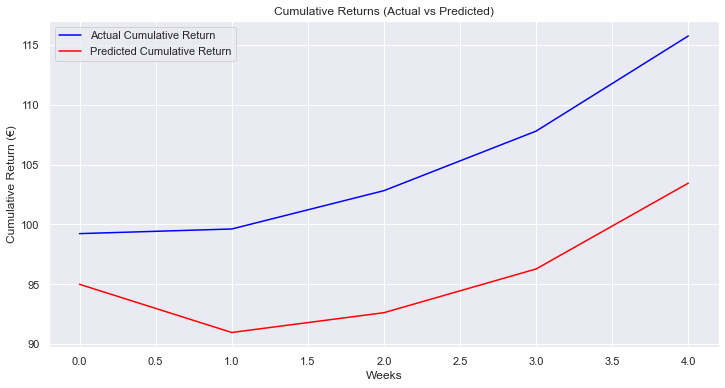

Mean Squared Error (MSE): 8.4095725250082
Root Mean Squared Error (RMSE): 2.899926296478619
Final Actual Cumulative Return: 115.73 EUR
Final Predicted Cumulative Return: 103.45 EUR
Percentage of MAX returns acheived: 21.93 %
[ 99.238095  99.625349 102.823199 107.792899 115.732679]
[ 95.00987  90.98977  92.64071  96.28876 103.45039]


In [27]:
predictions.sort_values(by=['date'], inplace=True)
cumulative_returns(predictions)

-----

The first classification approach with XGBoost wa ssupposed to be a baseline and also to check how time structured data would be handled by one of the most commonly used models, however it struggled with predicting the minority class (best stock), resulting in misleadingly high accuracy due to predicting the majority class.

Prophet is supposedly good at capturing trends and seasonality, which is essential in financial markets where cycles and trends are crucial for predicting price changes. I think the limited time horizon of the data made it difficult for the LSTM and Prophet models to capture complex sequential data, reducing its effectiveness.

-----

## Conclusions
In the conclusions, you should enumerate the results you got after completing the challenge.
* How good do you consider your results? 
* What are some factors that would contribute to get better results?
* What are some advantages and disadvantages of your solution?
* What can be done as future work to improve your results?


-----
I was initially expecting for better result spetialy when using time series models, Prophet and the LSTM did a good enough job to at least provide some profits in the given problem but they came very short of the overall best returns possible. Prophet is particularly effective in identifying long-term patterns but may not capture short-term price spikes or dips, making it less suited for predicting sudden changes in stock performance.

XGBoost is easy to interpret, allowing us to see which features are most important for stock performance however it didnt have any real capability to predict the best stock class as it doesnt do well in very unbalanced datasets as is the case.

Better feature engineering should be a focus as adding more advanced stock market indicators could possibly help improve the model’s ability to capture market trends and make better predictions. 

I would love to try the same problem expanding the dataset to include a longer time horizon (e.g., years of historical data instead of just a few months) would allow the models, especially LSTM and Prophet, to better capture long-term trends and improve performance.

If given more time i would have liked to try other Time series out models such as GRU, Transformer-based models, or GARCH for volatility forecasting could help improve predictions of sharp price movements.

-----

#### Feedback

-----
*Add here your thoughts and feedback regarding this challenge.*

-----

To submit your solution you should e-mail us this notebook in response to the e-mail you initially received with the challenge.